In [1]:
# !pip install diskcache
# !pip install --user google-genai

In [2]:
# Uncomment line below to install exlib
# !pip install diskcache
import sys; 
sys.path.append('../src')

ROOT_DIR = '..'

import openai
import os

# with open(f"{ROOT_DIR}/API_KEY.txt", "r") as file:
#     api_key = file.read().strip()
with open(f"{ROOT_DIR}/API_KEY2.txt", "r") as file:
    api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir3')


In [3]:
import torch
from datasets import load_dataset

test_dataset = load_dataset("BrachioLab/massmaps-cosmogrid-100k", split='test')
test_dataset.set_format('torch', columns=['input', 'label'])

In [4]:
import importlib
import sys; sys.path.append("../src")
import massmaps
importlib.reload(massmaps)
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer, get_llm_output
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_scores

In [5]:
from tqdm.auto import tqdm
import json

# Save first step

In [ ]:
model = 'gpt-4o'

methods = ['vanilla', 'cot', 'socratic', 'subq']

num_examples = 100
# num_examples = 20

all_massmaps_examples = {}

for method in tqdm(methods):
    print(method)
    massmaps_examples = []
    # save intermediate
    save_dir = f'_dump/massmaps/intermediate/{model}/{method}'
    os.makedirs(save_dir, exist_ok=True)
    for idx in tqdm(range(num_examples)):
        save_path = os.path.join(save_dir, f'{idx}.json')
        # if os.path.exists(save_path):
        #     continue
        X, y = test_dataset[idx:idx+1]['input'], test_dataset[idx:idx+1]['label']
        image = X[0]
        label = y[0]
        llm_answer, llm_explanation = get_llm_generated_answer(
            image, 
            method=method, 
            model=model
        )
        if llm_answer is None:
            continue
        example = MassMapsExample(
            input=image,
            answer={"Omega_m": label[0].item(), "sigma_8": label[1].item()},
            llm_answer=llm_answer,
            llm_explanation=llm_explanation
        )
        massmaps_examples.append(example)
        
        # save intermediate
        save_dict = {}
        for k, v in example.__dict__.items():
            save_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()
        with open(save_path, 'wt') as output_file:
            json.dump(save_dict, output_file)
    all_massmaps_examples[method] = massmaps_examples

  0%|          | 0/4 [00:00<?, ?it/s]

vanilla


  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import mean_squared_error
import torch
from scipy.stats import pearsonr

# indices for which all four prompting methods returned a non-None answer
# common_idxs = set.intersection(*(set(m.keys()) for m in results_all.values()))
# common_idxs = list(range(20))
print(sorted(common_idxs))


# Store results
mse_results = {}

for method in methods:
    print(f"\nMethod: {method}")
    massmaps_examples = all_massmaps_examples[method]

    gt_omega_m = []
    gt_sigma_8 = []
    pred_omega_m = []
    pred_sigma_8 = []

    # for idx, example in massmaps_examples.items():
    for idx in common_idxs:
        example = massmaps_examples[idx]
        answer = example.answer  # dict with 'Omega_m', 'sigma_8'
        llm_answer = example.llm_answer  # dict with 'Omega_m', 'sigma_8'

        gt_omega_m.append(answer['Omega_m'])
        gt_sigma_8.append(answer['sigma_8'])
        pred_omega_m.append(llm_answer['Omega_m'])
        pred_sigma_8.append(llm_answer['sigma_8'])

    # Compute MSE
    mse_omega_m = mean_squared_error(gt_omega_m, pred_omega_m)
    mse_sigma_8 = mean_squared_error(gt_sigma_8, pred_sigma_8)

    # Store
    mse_results[method] = {
        'mse_Omega_m': mse_omega_m,
        'mse_sigma_8': mse_sigma_8,
    }

    print(f"MSE Omega_m: {mse_omega_m:.4f}")
    print(f"MSE sigma_8: {mse_sigma_8:.4f}")


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Method: vanilla
MSE Omega_m: 0.0144
MSE sigma_8: 0.0819

Method: cot
MSE Omega_m: 0.0144
MSE sigma_8: 0.0701

Method: socratic
MSE Omega_m: 0.0150
MSE sigma_8: 0.0843

Method: subq
MSE Omega_m: 0.0163
MSE sigma_8: 0.0686


# Load and do evaluation

In [14]:
import json
import os
from collections import defaultdict
from tqdm.auto import tqdm

model = 'gpt-4o'
eval_model = 'gpt-4o'
methods = ['vanilla', 'cot', 'socratic', 'subq']
num_check = 100

# Step 1: collect filenames per method
filenames_per_method = {}

for method in methods:
    load_dir = f'_dump/massmaps/intermediate/{model}/{method}'
    filenames = set(os.listdir(load_dir))
    filenames_per_method[method] = filenames

# Step 2: compute intersection
common_filenames = set.intersection(*filenames_per_method.values())
common_filenames = sorted(list(common_filenames), key=lambda x: int(x.split('.')[0]))[:num_check]  # optional: limit to num_check
print(len(common_filenames))
# Step 3: load files
all_results = defaultdict(list)

for method in tqdm(methods):
    load_dir = f'_dump/massmaps/intermediate/{model}/{method}'
    for filename in common_filenames:
        path = os.path.join(load_dir, filename)
        with open(path, 'rt') as input_file:
            data = json.load(input_file)
        all_results[method].append(data)


100


  0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
common_filenames[:10]

['0.json',
 '1.json',
 '2.json',
 '3.json',
 '4.json',
 '5.json',
 '6.json',
 '7.json',
 '8.json',
 '9.json']

In [6]:
all_results['vanilla'][0].keys()

dict_keys(['input', 'answer', 'llm_answer', 'llm_explanation', 'claims', 'relevant_claims', 'alignment_scores', 'alignment_categories', 'alignment_reasonings'])

In [15]:
final_examples = defaultdict(list)
for method in tqdm(methods):
    save_dir = f'_dump/massmaps/final/{model}/{method}'
    os.makedirs(save_dir, exist_ok=True)
    for idx in tqdm(range(len(all_results[method]))):
        save_path = os.path.join(save_dir, common_filenames[idx])
        # if os.path.isfile(save_path):
        #     continue
        
        # load
        example_dict = all_results[method][idx]
        
        if not isinstance(example_dict['input'], torch.Tensor):
            example_dict['input'] = torch.tensor(example_dict['input'])

        example = MassMapsExample(
            input = example_dict['input'],
            answer = example_dict['answer'],
            llm_answer = example_dict['llm_answer'],
            llm_explanation = example_dict['llm_explanation'],
        )
        example.__dict__ = example_dict
    
        # isolate individual features
        claims = isolate_individual_features(example.llm_explanation, model=eval_model)
        if claims is None:
            continue
        example.claims = [claim.strip() for claim in claims]
        
        # distill relevant features
        relevant_claims = distill_relevant_features(
            example.input, 
            example.llm_answer,
            example.claims,
            model=eval_model
        )
        example.relevant_claims = relevant_claims
        
        # calculate expert alignment scores
        align_infos = calculate_expert_alignment_scores(example.relevant_claims, eval_model)

        example.alignable_claims = [info["Claim"] for info in align_infos]
        example.alignment_categories = [info["Category"] for info in align_infos]
        example.aligned_category_ids = [info["Category ID"] for info in align_infos]
        example.alignment_scores = [info["Alignment"] for info in align_infos]
        example.alignment_reasonings = [info["Reasoning"] for info in align_infos]

        # Non-alignable claims are given a score of 0.0
        if len(align_infos) > 0:
            example.final_alignment_score = sum(info["Alignment"] for info in align_infos) / len(example.claims)
        else:
            example.final_alignment_score = 0.0
        
        # save
        save_dict = {}
        for k, v in example.__dict__.items():
            save_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()
        with open(save_path, 'wt') as output_file:
            json.dump(save_dict, output_file)
        final_examples[method].append(example)
        

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Save to results directory

In [17]:
import json
import os
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

model = 'gpt-4o'
methods = ['vanilla', 'cot', 'socratic', 'subq']
num_check = 100

# Step 1: collect filenames per method
filenames_per_method = {}

for method in methods:
    load_dir = f'_dump/massmaps/final/{model}/{method}'
    filenames = set(os.listdir(load_dir))
    filenames_per_method[method] = filenames

# Step 2: compute intersection
common_filenames = set.intersection(*filenames_per_method.values())
common_filenames = sorted(list(common_filenames))[:num_check]  # optional: limit to num_check
print(len(common_filenames))
# Step 3: load files
all_results = defaultdict(list)

for method in tqdm(methods):
    load_dir = f'_dump/massmaps/final/{model}/{method}'
    for filename in common_filenames:
        path = os.path.join(load_dir, filename)
        with open(path, 'rt') as input_file:
            data = json.load(input_file)
        mse_omega_m = mean_squared_error(
            [data['answer']['Omega_m']], 
            [data['llm_answer']['Omega_m']]
        )
        mse_sigma_8 = mean_squared_error(
            [data['answer']['sigma_8']], 
            [data['llm_answer']['sigma_8']]
        )
        data['mse_loss'] = {'Omega_m': mse_omega_m, 'sigma_8': mse_sigma_8}
        data['final_alignment_score'] = sum(data['alignment_scores']) / len(data['claims'])
        all_results[method].append(data)


100


  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
all_results.keys()

dict_keys(['vanilla', 'cot', 'socratic', 'subq'])

In [18]:
import json

for method in all_results:
    save_path = os.path.join(ROOT_DIR, 'results', method, f'massmaps_{model}.json')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wt') as output_file:
        json.dump(all_results[method], output_file, indent=4)

# Get User Study Examples

In [19]:
import json

load_path = os.path.join(ROOT_DIR, 'results/vanilla/massmaps_gpt-4o.json')

with open(load_path) as input_file:
    results = json.load(input_file)

In [21]:
results[0].keys()

dict_keys(['input', 'answer', 'llm_answer', 'llm_explanation', 'claims', 'relevant_claims', 'alignment_scores', 'alignment_categories', 'alignment_reasonings', 'alignable_claims', 'aligned_category_ids', 'final_alignment_score', 'mse_loss'])

In [26]:
import random

random.seed(42)    
idxs = list(range(len(results)))
sampled_idxs = random.sample(idxs, k=5)
sampled_idxs

[81, 14, 3, 94, 35]

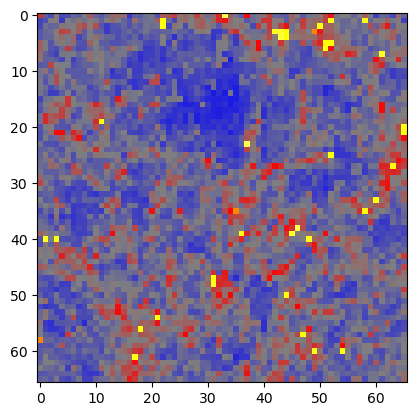

Example 81
Ground Truth Answer: Omega_m: 0.15781250596046448, sigma_8: 0.9742187261581421
LLM Generated Answer: Omega_m: 0.3, sigma_8: 1.0

--- LLM Explanation ---
The map shows a predominance of blue and gray areas, indicating a significant amount of underdense regions with some overdense regions marked by red and yellow. The fluctuation pattern suggests a moderate level of matter distribution clumpiness, with notable dense structures present. These characteristics point to a moderate value of Omega_m and a moderate to high value of sigma_8.

--- Final Filtered Claims from LLM Explanation ---
Claim: The map shows a predominance of blue and gray areas.
Alignment category: Void Size and Frequency, Score: 0.6

Claim: Blue and gray areas indicate a significant amount of underdense regions.
Alignment category: Void Size and Frequency, Score: 0.7

Claim: There are some overdense regions marked by red and yellow.
Alignment category: Lensing Peak (Cluster) Abundance, Score: 0.6

Claim: The fl

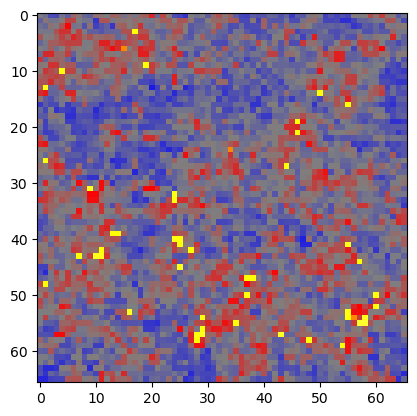

Example 14
Ground Truth Answer: Omega_m: 0.4359374940395355, sigma_8: 0.5601562261581421
LLM Generated Answer: Omega_m: 0.3, sigma_8: 0.8

--- LLM Explanation ---
The map shows a mix of colors, with areas of blue indicating negative mass deviation, red indicating positive mass deviation, and yellow marking regions of significant mass concentration (above 2.9 standard deviations). The widespread presence of blue and red implies moderate density fluctuations, while the scattered yellow regions suggest some high concentration areas. Overall, this distribution points to a balanced matter-energy density and moderate structure formation.

--- Final Filtered Claims from LLM Explanation ---
Claim: Areas of red in the map indicate positive mass deviation.
Alignment category: Density Contrast Extremes, Score: 0.3

Claim: Yellow regions mark areas of significant mass concentration, above 2.9 standard deviations.
Alignment category: Lensing Peak (Cluster) Abundance, Score: 0.9

Claim: The widespre

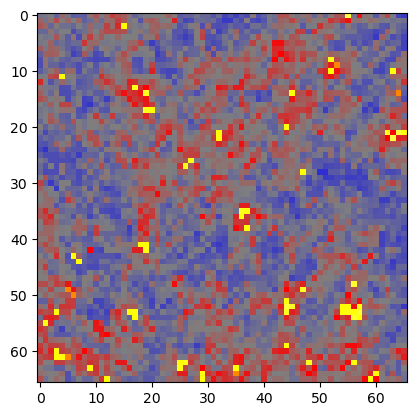

Example 3
Ground Truth Answer: Omega_m: 0.3726562559604645, sigma_8: 0.7066406011581421
LLM Generated Answer: Omega_m: 0.3, sigma_8: 0.9

--- LLM Explanation ---
The weak lensing map shows a mix of colors indicating a range of matter density fluctuations. The presence of blue areas suggests regions below average density, while red and yellow areas indicate moderate to high fluctuations, typical of cosmic web structures like filaments and clusters. The prominence of red and yellow suggests a universe with significant matter fluctuations.

--- Final Filtered Claims from LLM Explanation ---
Claim: The presence of blue areas suggests regions below average density.
Alignment category: Void Size and Frequency, Score: 0.6

Claim: Red and yellow areas indicate moderate to high fluctuations.
Alignment category: Density Contrast Extremes, Score: 0.7

Claim: The prominence of red and yellow suggests a universe with significant matter fluctuations.
Alignment category: Density Contrast Extremes, Sc

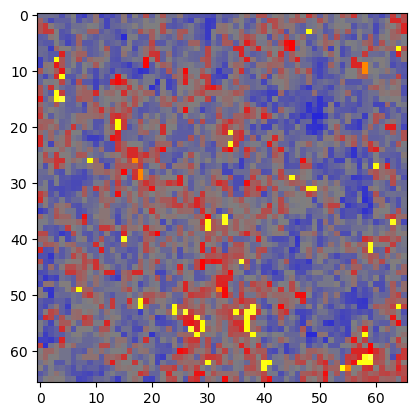

Example 94
Ground Truth Answer: Omega_m: 0.2955078184604645, sigma_8: 0.9454101324081421
LLM Generated Answer: Omega_m: 0.3, sigma_8: 1.0

--- LLM Explanation ---
The weak lensing map shows a mix of negative (blue), neutral (gray), and positive (red to yellow) fluctuations in the matter distribution. The presence of prominent yellow regions indicates areas with significant matter distribution above 2.9 sigma, suggesting higher fluctuations. This pattern suggests a moderately high sigma_8, depicting more pronounced matter clustering. The mix of colors, with significant gray areas but noticeable reds and yellows, suggests a moderate Omega_m, indicating a balanced matter density relative to total energy density.

--- Final Filtered Claims from LLM Explanation ---
Claim: The presence of prominent yellow regions indicates areas with significant matter distribution above 2.9 sigma.
Alignment category: Lensing Peak (Cluster) Abundance, Score: 0.9

Claim: The areas with significant matter dist

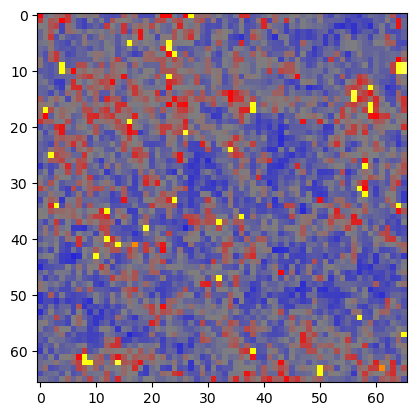

Example 35
Ground Truth Answer: Omega_m: 0.32792967557907104, sigma_8: 0.8370116949081421
LLM Generated Answer: Omega_m: 0.25, sigma_8: 0.9

--- LLM Explanation ---
The map displays a noticeable amount of blue and gray with significant red clustering, indicating negative and moderate mass fluctuations and areas with some dense structures. The appearance of yellow spots suggests a few high-density peaks. This combination implies a lower to moderate matter density with noticeable fluctuations in structure.

--- Final Filtered Claims from LLM Explanation ---
Claim: The map displays a noticeable amount of blue and gray with significant red clustering.
Alignment category: Density Contrast Extremes, Score: 0.8

Claim: The blue and gray indicate negative and moderate mass fluctuations.
Alignment category: Density Contrast Extremes, Score: 0.3

Claim: The significant red clustering indicates areas with some dense structures.
Alignment category: Lensing Peak (Cluster) Abundance, Score: 0.7

Cla

In [59]:
import matplotlib.pyplot as plt
import torch

for idx in sampled_idxs:
    result = results[idx]
    plt.figure()
    plt.imshow(massmap_to_pil_norm(torch.tensor(results[idx]['input']), scale=1))
    os.makedirs('user_study/massmaps', exist_ok=True)
    plt.savefig(f'user_study/massmaps/{idx}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    # readable input (image of time series data)
    # ground truth answer
    # LLM generated answer
    # LLM explanation
    # final filtered claims + alignment scores

    # dict_keys(['input', 'answer', 'llm_answer', 'llm_explanation', 'claims', 'relevant_claims', 'alignment_scores', 'alignment_categories', 'alignment_reasonings', 'alignable_claims', 'aligned_category_ids', 'final_alignment_score', 'mse_loss'])
    print(f'Example {idx}')
    print(f"Ground Truth Answer: Omega_m: {result['answer']['Omega_m']}, sigma_8: {result['answer']['sigma_8']}")
    print(f"LLM Generated Answer: Omega_m: {result['llm_answer']['Omega_m']}, sigma_8: {result['llm_answer']['sigma_8']}")
    print()
    print(f"--- LLM Explanation ---")
    print(result['llm_explanation'])
    print()
    print(f"--- Final Filtered Claims from LLM Explanation ---")
    for ci, claim in enumerate(result['relevant_claims']):
        print("Claim:", claim)
        if claim in result['alignable_claims']:
            new_ci = result['alignable_claims'].index(claim)
            
            print(f"Alignment category: {result['alignment_categories'][new_ci]}, Score: {result['alignment_scores'][new_ci]}")
            # print(result['alignment_categories'][new_ci], result['alignment_scores'][new_ci], claim)
        else:
            print("Not aligned")
        print()
            # print('None', 0, claim)
            
    print()
    print()

In [28]:
import importlib
import sys; sys.path.append("../src")
import massmaps
importlib.reload(massmaps)
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer, get_llm_output
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_scores

In [42]:
result = results[idx]

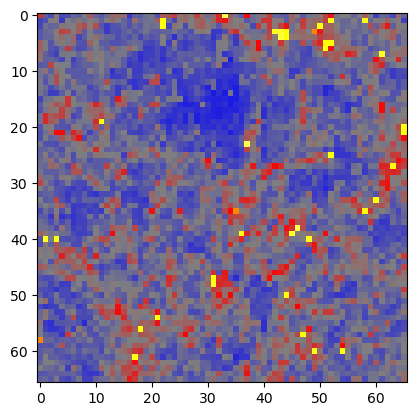

In [43]:
import matplotlib.pyplot as plt
import torch

plt.figure()
plt.imshow(massmap_to_pil_norm(torch.tensor(results[idx]['input']), scale=1))
os.makedirs('user_study/massmaps', exist_ok=True)
plt.savefig(f'user_study/massmaps/{idx}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [50]:
# readable input (image of time series data)
# ground truth answer
# LLM generated answer
# LLM explanation
# final filtered claims + alignment scores

# dict_keys(['input', 'answer', 'llm_answer', 'llm_explanation', 'claims', 'relevant_claims', 'alignment_scores', 'alignment_categories', 'alignment_reasonings', 'alignable_claims', 'aligned_category_ids', 'final_alignment_score', 'mse_loss'])
print(idx)
print(f"Ground Truth Answer: Omega_m: {result['answer']['Omega_m']}, sigma_8: {result['answer']['sigma_8']}")
print(f"LLM Generated Answer: Omega_m: {result['llm_answer']['Omega_m']}, sigma_8: {result['llm_answer']['sigma_8']}")
print()
print(f"--- LLM Explanation ---")
print(result['llm_explanation'])
print()
print(f"--- Final Filtered Claims from LLM Explanation ---")
for ci, claim in enumerate(result['relevant_claims']):
    if claim in result['alignable_claims']:
        new_ci = result['alignable_claims'].index(claim)
        print(result['alignment_categories'][new_ci], result['alignment_scores'][new_ci], claim)
    else:
        print('None', 0, claim)

81
Ground Truth Answer: Omega_m: 0.15781250596046448, sigma_8: 0.9742187261581421
LLM Generated Answer: Omega_m: 0.3, sigma_8: 1.0

--- LLM Explanation ---
The map shows a predominance of blue and gray areas, indicating a significant amount of underdense regions with some overdense regions marked by red and yellow. The fluctuation pattern suggests a moderate level of matter distribution clumpiness, with notable dense structures present. These characteristics point to a moderate value of Omega_m and a moderate to high value of sigma_8.

--- Final Filtered Claims from LLM Explanation ---
Void Size and Frequency 0.6 The map shows a predominance of blue and gray areas.
Void Size and Frequency 0.7 Blue and gray areas indicate a significant amount of underdense regions.
Lensing Peak (Cluster) Abundance 0.6 There are some overdense regions marked by red and yellow.
Fine-Scale Clumpiness 0.6 The fluctuation pattern suggests a moderate level of matter distribution clumpiness.
Lensing Peak (Clus

# Get relevance few shot examples

In [34]:
from PIL import Image
import numpy as np
import torch

def massmap_to_pil_norm2(
    tensor: torch.Tensor,
    mean_center: bool = False,
    vmin: float = -3,
    vmax: float = 20,
    colors: list = None,
    scale: int = 11          # ← new: integer zoom factor
) -> Image.Image:
    """
    Convert a (1,H,W) tensor → PIL Image (H×W), with:
      • optional mean-centering
      • divide-by-std normalization
      • clip to [vmin,vmax], then min–max to [0,1]
      • apply custom colormap ⇒ RGB
      • optional nearest-neighbor up-scaling by integer *scale*
    """
    # 1) pull out H×W array
    arr = tensor.detach().cpu().numpy()[0]  # shape (H, W)

    # 2) normalize
    if mean_center:
        arr = arr - arr.mean()
    arr = arr / (arr.std() + 1e-8)

    # 3) clip & rescale to [0,1]
    arr = np.clip(arr, vmin, vmax)
    arr = (arr - vmin) / (vmax - vmin)

    # 4) colormap
    cmap = get_custom_colormap(colors)
    rgba = cmap(arr)                # (H, W, 4) floats in [0,1]
    rgb  = (rgba[..., :3] * 255).astype(np.uint8)

    # 5) make PIL Image
    img = Image.fromarray(rgb)

    # 6) optional nearest-neighbor enlargement
    if scale > 1:
        new_size = (img.width * scale, img.height * scale)
        img = img.resize(new_size, resample=Image.NEAREST)

    return img


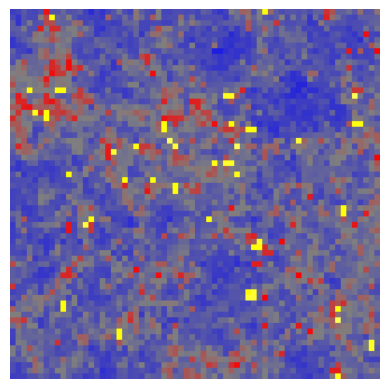

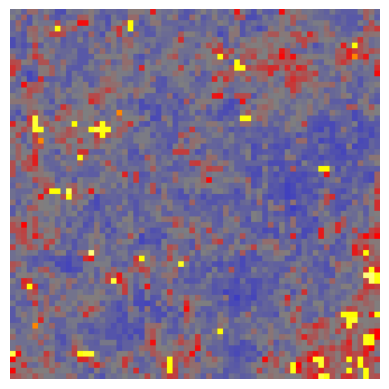

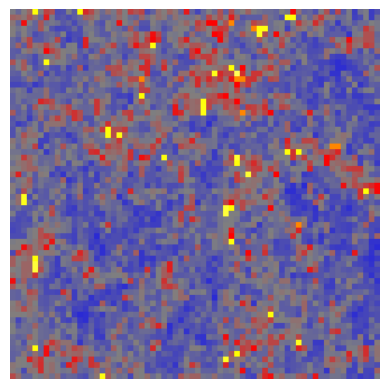

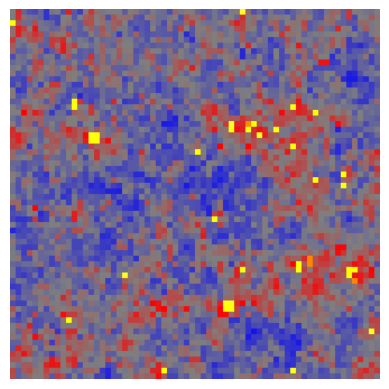

In [35]:
from massmaps import massmap_to_pil_norm, get_custom_colormap
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset

train_dataset = load_dataset("BrachioLab/massmaps-cosmogrid-100k", split='train')
train_dataset.set_format('torch', columns=['input', 'label'])

os.makedirs(os.path.join(ROOT_DIR, 'src/prompts/data'), exist_ok=True)
few_shot_numbers = [0, 2, 14, 19]
relevance_few_shot_examples = []
for i, idx in enumerate(few_shot_numbers):
    X, y = train_dataset[idx:idx+1]['input'], train_dataset[idx:idx+1]['label']
    relevance_few_shot_examples.append({'idx': idx, 'X': X, 'y': y})
    plt.figure()
    plt.imshow(massmap_to_pil_norm2(X[0]))
    plt.axis('off')
    # plt.title(f'$\Omega_m$ {round(y[0][0].item(), 4)},   $\sigma_8$ {round(y[0][1].item(), 4)}')
    plt.savefig(os.path.join(ROOT_DIR, f'src/prompts/data/massmaps_relevance_few_shot_examples.{i}.Omega{round(y[0][0].item(), 4)}.sigma{round(y[0][1].item(), 4)}.png'), 
                dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [30]:
for idx in range(10):
    print(train_dataset[idx:idx+1]['label'])

tensor([[0.1041, 0.9396]])
tensor([[0.3934, 0.7018]])
tensor([[0.2000, 1.1500]])
tensor([[0.4834, 0.6632]])
tensor([[0.1182, 1.3888]])
tensor([[0.3461, 0.6949]])
tensor([[0.4480, 0.5182]])
tensor([[0.2418, 0.7213]])
tensor([[0.4926, 0.4537]])
tensor([[0.4129, 0.4342]])
